Notebook adapted from Zoe Ashwood

## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

# TODO:
1. Add bias term
2. State permutations to match up states across animalss
3. Neural reward response by state
4. Hyperparameter sweeps

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append(f'{os.path.expanduser("~")}/GitHub/behavior-helpers/')
sys.path.append(f'{os.path.expanduser("~")}/GitHub/neural-timeseries-analysis/')

from bh.data.datasets import HFTrials
from bh.models.glmhmm import GLMHMM
from bh.models import model_plots as mp

%load_ext autoreload
%autoreload 2

In [2]:
train_split = 0.80
seed = 0
n_iters = 200
model_kwargs = {'transitions': 'sticky',
                'trans_kwargs': {'alpha': 2, 'kappa': 0},
                'obs_kwargs': {'C': 2, 'prior_sigma': 2}
}

# seed = np.random.randint(1000)
print(seed)

0


#### 1a. Import your data

In [ ]:
rand_X= pd.DataFrame(data={'a': np.random.randint(2, size=10000),
                                'b': np.random.randint(2, size=10000),
                                'Session': np.random.choice(['c','d', 'e', 'f'], size=10000)})
rand_y = pd.DataFrame(data={'a': np.random.randint(2, size=10000)})
rand_y['Session'] = rand_X['Session'].copy()


In [3]:
def pm1(x):
    return 2 * x - 1
feat_funcs = {
            'direction': lambda r, c: pm1(c),
            'dir-rew': lambda r, c: r * pm1(c)
            }

In [4]:
mice = ['C37', 'C38', 'C39', 'C40', 'C41', 'C43', 'C48']
mouse_models = {}

for mouse in mice:

    data = HFTrials(mice=mouse, verbose=False)
    model = GLMHMM(num_states=[1, 2, 3, 4], **model_kwargs)
    model.prepare_features(data.trials.copy(), 'direction', feat_funcs=feat_funcs, nlags=3)

    model.split_data(ptrain=train_split, verbose=False)
    model.init_model()
    lls, scores = model.fit_cv(n_iters=n_iters)
    model.compare_k_states(scores)
    model.LL = model.calc_log_likelihood(verbose=False)
    model.LL_norm = model.calc_log_likelihood(verbose=False, normalize=True)
    model.bits = model.calc_log_likelihood(verbose=False, as_bits=True)
    model.aic = {'test': model.calc_aic(model.LL)}
    model.predict_state()
    model.acc = {'test': model.predict_choice(accuracy=True, verbose=False)}
    model.pred_occupancy()

    mouse_models[mouse] = model


C37: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ 1. -1.]
[ 1.  0. -1.]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

C48: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


86 total sessions loaded in
[ 1. -1.]
[ 1.  0. -1.]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Model with 0 state(s) has a test predictive accuracy of 0.9055026249270853
Model with 1 state(s) has a test predictive accuracy of 0.9049193077970057
Model with 2 state(s) has a test predictive accuracy of 0.9016138440598872
Model with 3 state(s) has a test predictive accuracy of 0.9018082831032471


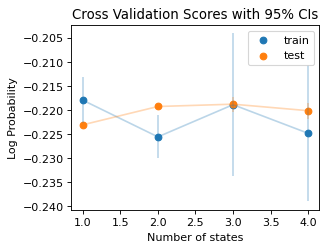

In [4]:
mouse = 'all'
mice = ['C37', 'C38', 'C39', 'C40', 'C41', 'C43', 'C48']

mouse_models = {}

data = HFTrials(mice=mice, verbose=False, label='all')
model = GLMHMM(num_states=[1, 2, 3, 4], **model_kwargs)
model.prepare_features(data.trials.copy(), 'direction', feat_funcs=feat_funcs, nlags=3)

model.split_data(ptrain=train_split, verbose=False)
model.init_model()
lls, scores = model.fit_cv(n_iters=n_iters)
model.compare_k_states(scores)
model.LL = model.calc_log_likelihood(verbose=False)
model.LL_norm = model.calc_log_likelihood(verbose=False, normalize=True)
model.bits = model.calc_log_likelihood(verbose=False, as_bits=True)
model.aic = {'test': model.calc_aic(model.LL)}
model.predict_state()
model.acc = {'test': model.predict_choice(accuracy=True, verbose=True)}
model.pred_occupancy()

mouse_models[mouse] = model

### 2a. Data and param set up

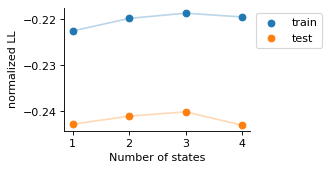

In [5]:
mp.compare_k_states(mouse_models, 'LL_norm', ylabel='normalized LL')

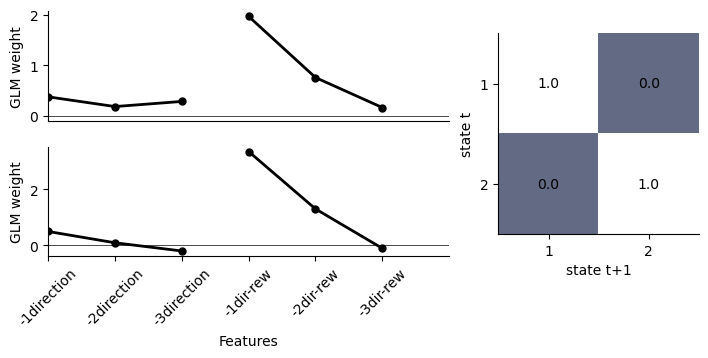

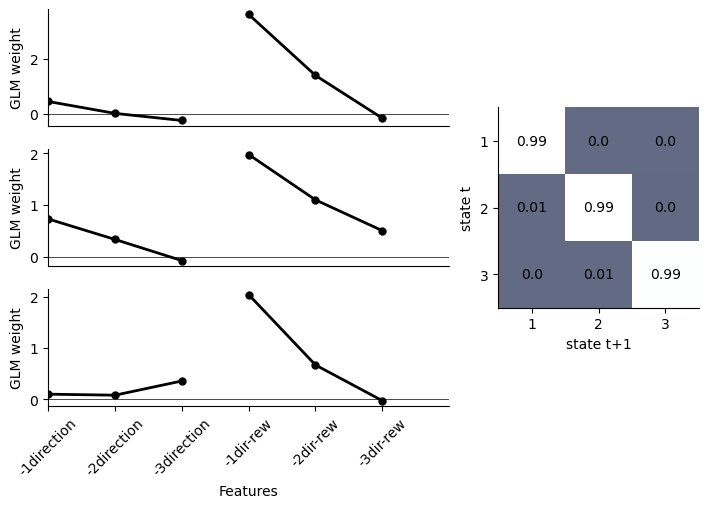

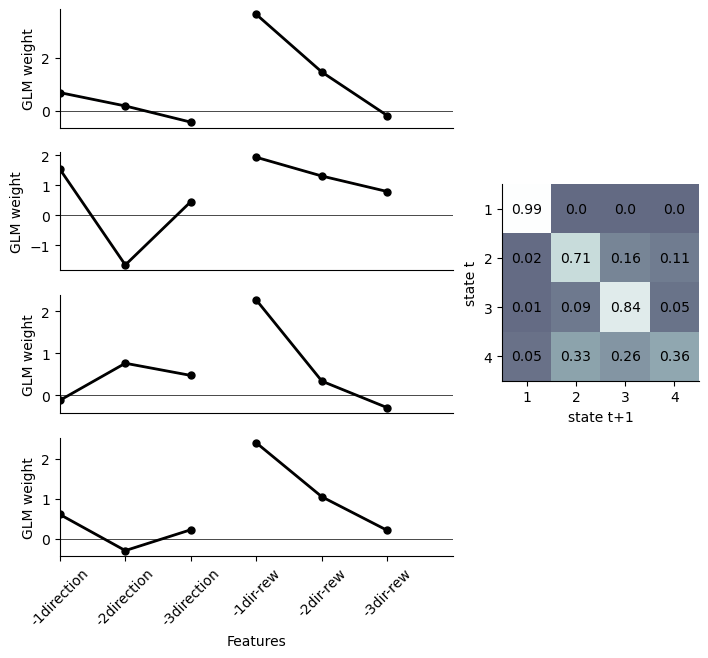

In [6]:
# by mouse only:
# mp.plot_glm_weights(mouse_models['C37'], 3)

for i in range(2,5):
    mp.plot_glm_weights(mouse_models, i, with_tmat=True)

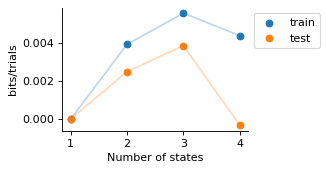

In [7]:
mp.compare_k_states(mouse_models, 'bits', ylabel='bits/trials')
# mp.compare_k_states(mouse_models, 'AIC', ylabel='AIC', datasets=['test'])
# mp.compare_k_states(mouse_models, 'accuracy', datasets=['test'], 
# ylim=(0,1), ylabel='Predictive Accuracy - Test Data')

IndexError: index 3 is out of bounds for axis 1 with size 3

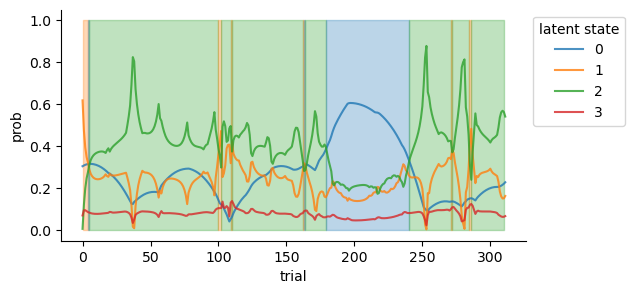

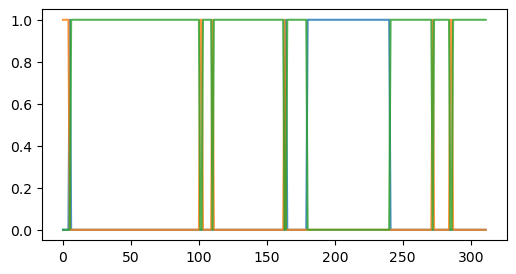

In [8]:
sess_id = 10
model_id= 3
mouse_models['all'].plot_state_probs(model_id, sess_idx=sess_id)
mouse_models['all'].plot_state_probs(model_id, sess_idx=sess_id, as_occupancy=True)

In [18]:
all_occ_rates = pd.DataFrame()
for mouse, model in mouse_models.items():
    
    occ_rates = pd.DataFrame({'Mouse': np.empty(4)})
    for i in range(4):
        occ_rates.loc[i, 'model'] = i
        # occ_rates[f'model{i}'] = np.nan
        occ_rates.loc[i, (f'state{i}' for i in range(i+1))] = model.test_occupancy_rates[i]
    occ_rates['Mouse'] = mouse
    all_occ_rates = pd.concat((all_occ_rates, occ_rates))

all_occ_rates = pd.melt(all_occ_rates, id_vars=['Mouse', 'model'],
                        value_vars=['state0', 'state1', 'state2', 'state3'])

In [19]:
all_occ_rates

,Mouse,model,variable,value
0,all,0.0,state0,1.000000
1,all,1.0,state0,0.209284
2,all,2.0,state0,0.102244
3,all,3.0,state0,0.000000
4,all,0.0,state1,NaN
5,all,1.0,state1,0.790716
6,all,2.0,state1,0.359678
7,all,3.0,state1,0.020717
8,all,0.0,state2,NaN
9,all,1.0,state2,NaN


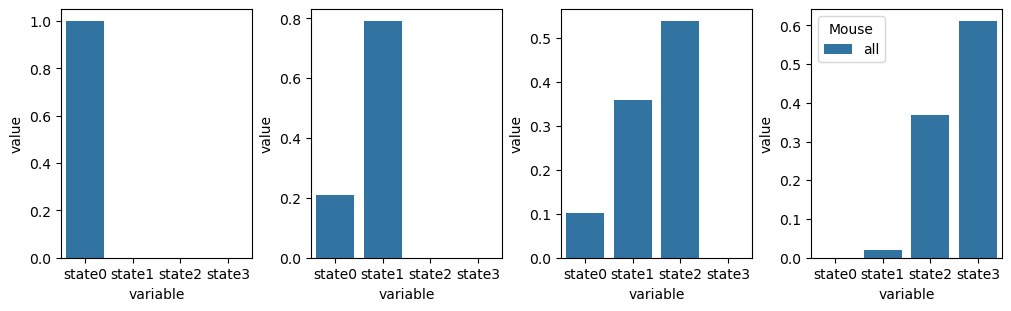

In [20]:
import seaborn as sns
fig, ax = plt.subplots(ncols=4, figsize=(10, 3), layout='constrained')
for i, ax_ in enumerate(ax):
    sns.barplot(all_occ_rates.query('model==@i'), x='variable', y='value', hue='Mouse', ax=ax_)
    if not i == 3:
        ax_.get_legend().remove()

In [175]:
from ssm.util import find_permutation

In [187]:
perm = find_permutation(np.concatenate(mouse_models['C40'].train_max_prob_state[1]), np.concatenate(mouse_models['C40'].train_max_prob_state[2]))

In [188]:
perm

array([2, 1, 0])

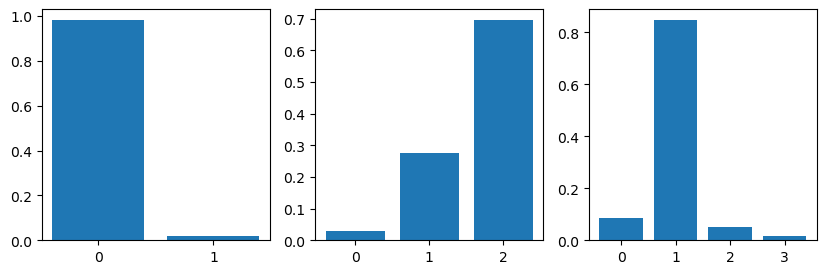

In [20]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))
for i in range(1,4):
    ax[i-1].bar(range(i+1), mouse_models['C40'].test_occupancy_rates[i])
    ax[i-1].set_xticks(range(i+1))

In [136]:
mouse_models['all'].acc = {'test': mouse_models['all'].predict_choice(accuracy=True, verbose=True, policy='prob_match')}
mouse_models['all'].acc

Model with 0 state(s) has a test predictive accuracy of 0.8540187991559562
Model with 1 state(s) has a test predictive accuracy of 0.8540187991559562
Model with 2 state(s) has a test predictive accuracy of 0.8586226740840207
Model with 3 state(s) has a test predictive accuracy of 0.8651448302321121


{'test': [0.8540187991559562,
  0.8540187991559562,
  0.8586226740840207,
  0.8651448302321121]}

In [104]:
from bh.utils import encode_as_rl, encode_sequences

n_states = 3
lag = 2
all_mice = pd.DataFrame()
for mouse, model in mouse_models.items():

    features = model.features
    choice_idx = np.where(features == '-1direction')[0][0]  # where in feature matrix is prev choice
    try:    
        reward_idx = np.where(features == '-1reward')[0][0]  # where in feature matrix is prev reward
    except IndexError:  # for when reward isn't explicitly in model
        reward_idx = np.where(features == '-1dir-rew')[0][0]

    # for i, (sess_x, sess_y) in enumerate(zip(model.test_X, model.pchoice[n_states])):
    sess_break_idx = np.insert(np.cumsum([len(sess) for sess in model.test_X]), 0, 0)
    X = model.test_X # np.concatenate(model.test_X, axis=0)
    y_flat = model.pchoice[n_states-1]
    y = [y_flat[sess_start:sess_stop] for sess_start, sess_stop in zip(sess_break_idx[:-1], sess_break_idx[1:])] 
    switches = []
    seqs = []
    for X_sess, y_sess in zip(X, y):
        sample_choices = X_sess[:, choice_idx]
        sample_rewards = np.abs(X_sess[:, reward_idx])  # take abs value so it works with rewards or interactions

        sess_diffs = np.insert(np.diff(y_sess), 0, 0)
        switches.append(np.abs(sess_diffs))
        # switches = np.abs(np.concatenate(sess_diffs, axis=0))

        seqs.append(encode_sequences(encode_as_rl(sample_choices, sample_rewards), lag=lag))

    latent_states = np.concatenate(model.test_max_prob_state[n_states-1])#[2:]
    tmp = pd.concat((all_mice, pd.DataFrame(data={'Mouse': mouse,
                             'nTrial': np.concatenate(model.test_trials),
                             'seq':np.concatenate(seqs),
                             'Switch': np.concatenate(switches),
                             'model_state':latent_states.astype('int')})))

data = mouse_models['all'].X_raw.copy()
data['model_state'] = data['nTrial'].map(tmp.set_index('nTrial')['model_state'])
# tmp['iInBlock'] = tmp['nTrial'].map(mouse_models['all'].X_raw.set_index('nTrial')['iInBlock'])
# tmp['iBlock'] = tmp['nTrial'].map(mouse_models['all'].X_raw.set_index('nTrial')['iBlock'])

In [84]:
import seaborn as sns

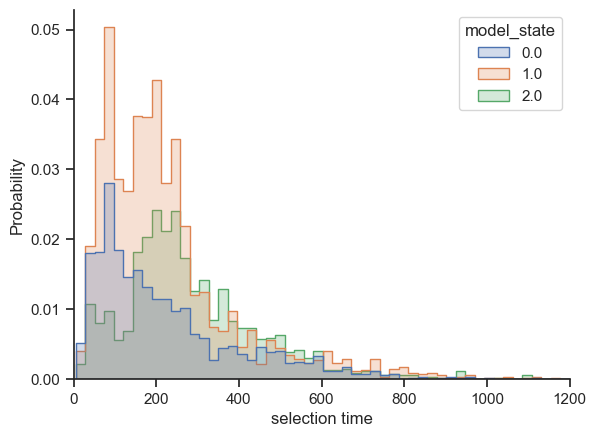

In [106]:
fig, ax = plt.subplots()
sns.histplot(data=data, hue='model_state', x='tSelection', element='step', ax=ax, palette='deep', stat='probability', common_norm=True)
# ax.set_xticks(np.arange(20, ste/p=5))
ax.set(xlabel='selection time', xlim=(0,1200))
sns.despine()

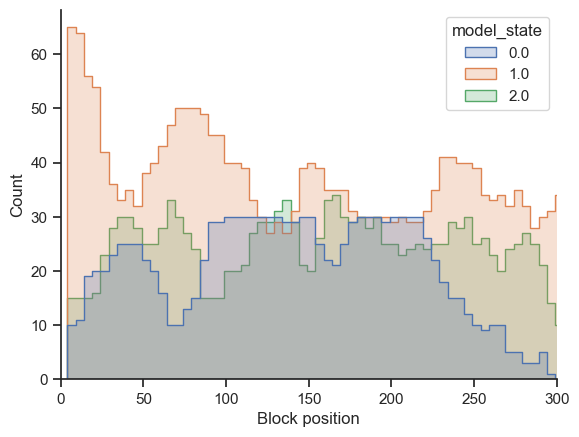

In [112]:
fig, ax = plt.subplots()
sns.histplot(data=data, hue='model_state', x='nTrial_orig', element='step', binwidth=5, ax=ax, palette='deep')
# ax.set_xticks(np.arange(20, step=5))
ax.set(xlabel='Block position', xlim=(0, 300))
sns.despine()

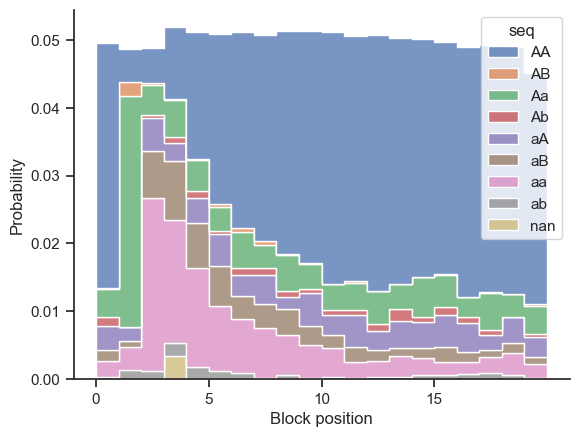

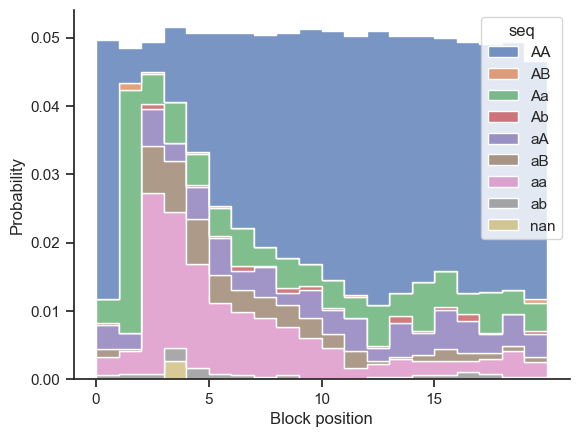

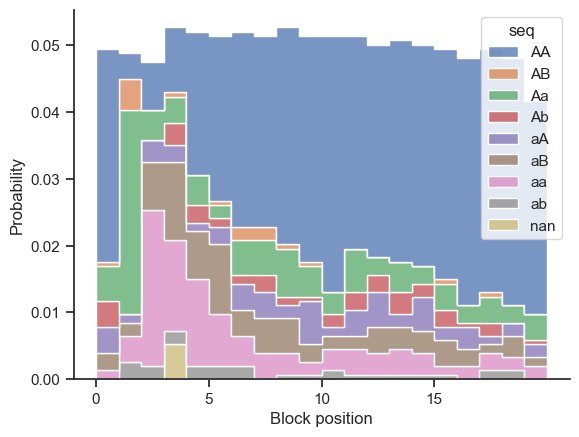

In [91]:
fig, ax = plt.subplots()
sns.histplot(data=tmp.sort_values(by='seq'), x='iInBlock', hue='seq', element='step', bins=range(21), multiple='stack', stat='probability', ax=ax)
ax.set_xticks(np.arange(20, step=5))
ax.set(xlabel='Block position')
sns.despine()

for i in range(n_states):
    fig, ax = plt.subplots()
    sns.histplot(data=tmp.query('model_state==@i').sort_values(by='seq'), x='iInBlock', hue='seq', element='step', bins=range(21), multiple='stack', stat='probability', ax=ax)
    ax.set_xticks(np.arange(20, step=5))
    ax.set(xlabel='Block position')
    sns.despine()

In [38]:
tmp['iInBlock'] = tmp['nTrial'].map(mouse_models['all'].X_raw.set_index('nTrial')['iInBlock'])
tmp.head()

,Mouse,nTrial,seq3,Switch,model_state,iInBlock
0,all,575.0,nan,0,0,3
1,all,576.0,nan,0,0,4
2,all,577.0,AAA,0,0,5
3,all,578.0,AAb,0,0,6
4,all,579.0,AbA,0,0,7


In [19]:
len(np.unique(np.concatenate(model.test_trials))) == len(np.concatenate(model.test_trials))

True

In [32]:
mouse_models['all'].X_raw[:580][['nTrial', '-1seq3', 'Session']]

,nTrial,-1seq3,Session
570,571.0,None,C37_2020_11_04
571,572.0,NaN,C37_2020_10_27
572,573.0,None,C37_2020_10_27
573,574.0,None,C37_2020_10_27
574,575.0,AAA,C37_2020_10_27
575,576.0,AAA,C37_2020_10_27
576,577.0,AAA,C37_2020_10_27
577,578.0,AAb,C37_2020_10_27
578,579.0,AbA,C37_2020_10_27
579,580.0,aBB,C37_2020_10_27


{'ABA', 'ABa'}
{'Aba', 'aAB', 'ABa', 'aBA', 'AbB', 'ABA'}


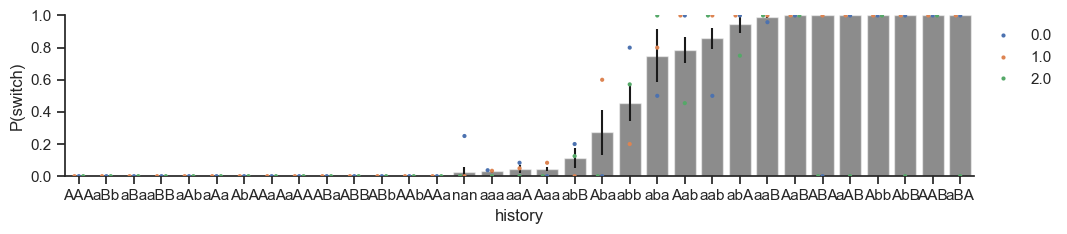

In [35]:
from bh.visualization import plot_trials as pts

pooled_policies = pts.calc_conditional_probs(tmp, 3, pred_col='Switch', sortby='pevent')
x_histories = pooled_policies.history.values
state_policies = pts.calc_conditional_probs(tmp, 3, pred_col='Switch', sortby='history', add_grps='model_state', order=x_histories)

fig, ax = pts.plot_sequences(pooled_policies, alpha=0.5, title='')
fig, ax = pts.plot_sequence_points(state_policies, fig=fig, ax=ax, grp='model_state', pal='deep')

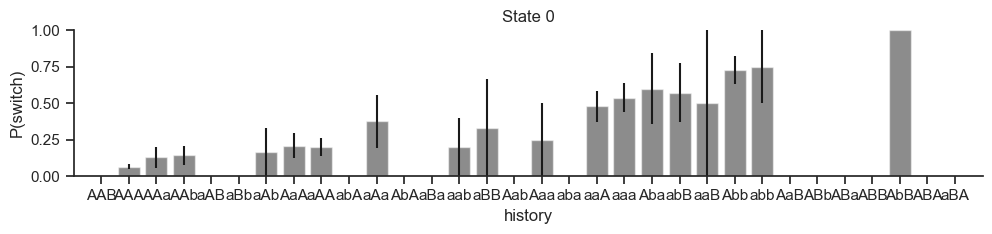

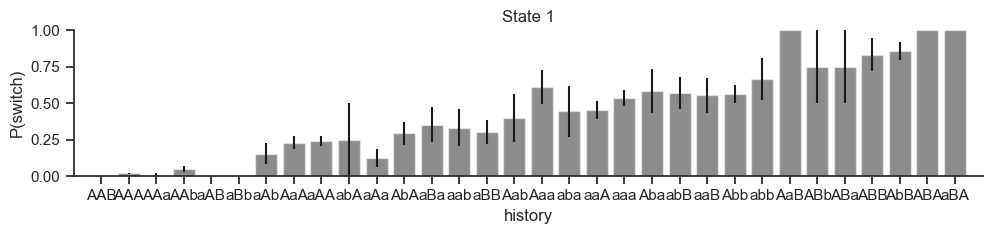

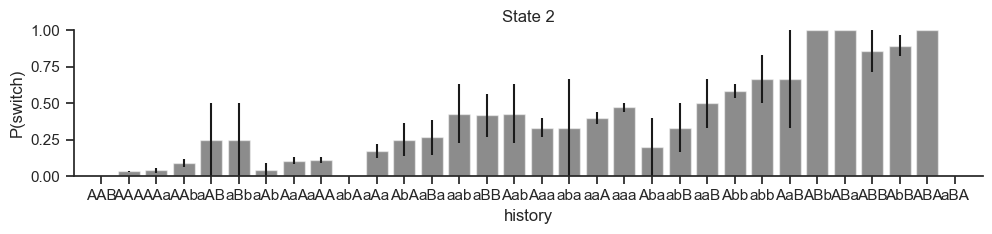

In [145]:
for i in range(n_states):
    fig, ax = pts.plot_sequences(state_policies.query('model_state==@i'), alpha=0.5, title=f'State {i}')


In [45]:
from plotly.subplots import make_subplots

n_cols = 3
n_rows = int(np.ceil(len(list(mouse_models.keys())) / n_cols))

fig = make_subplots(rows=n_rows, cols=n_cols,
                    subplot_titles=list(mouse_models.keys()),
                    start_cell="top-left", 
                    specs=[[{'type': 'sunburst'} for col in range(n_cols)] for row in range(n_rows)],
                    vertical_spacing=0.07,
                    horizontal_spacing=0.02,
                    )

for j, (mouse, model) in enumerate(mouse_models.items()):
    trial_ids = np.concatenate(model.train_trials)
    occ_by_model = pd.DataFrame(data={'nTrial': trial_ids})

    for i, occ in enumerate(model.train_max_prob_state):
        occ_by_model[f'model_state{i}'] = np.concatenate(occ)
    
    occ_counts = occ_by_model.groupby([f'model_state{i}' for i in range(4)], as_index=False)['model_state3'].value_counts()

    fig = mp.add_sunburst_subplot(occ_counts, mouse, fig, j)#, branchvalues='total')

fig.update_layout(height=700, width=700,
                  margin_r=15., margin_t=25., margin_b=15., margin_l=15.)
fig.show()

### 2b. Option 2 -- Stationary HMM -- input driven, looping through states. Much the same as above except, we are changing the transitions to 'standard'.

In [ ]:

map_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="input_driven_obs", 
            observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma),
            transitions="standard")


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]